[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/veselm73/SU2/blob/main/notebooks/SU2_StarDist_final.ipynb)

# StarDist Cell Detection Training Pipeline

This notebook trains a StarDist model for cell detection using K-Fold cross-validation.

**Key Features:**
- StarDist architecture with configurable backbone (ResNet18/34/50, EfficientNet)
- Combined loss function (Focal + Dice + Smooth L1)
- Data augmentation with albumentations
- Regularization: Weight decay + LR scheduling + Early stopping
- Post-training threshold sweep for optimal prob_thresh/nms_thresh
- Tracking evaluation with HOTA metric and LapTrack parameter sweep

**Data Sources:**
- Validation video: Downloaded from UTIA server
- Bonus training data: Fetched from GitHub repository (annotated frames)

**Outputs:**
- Trained StarDist model (best fold)
- Detection predictions CSV
- Training curves and metrics
- Tracking visualization

## 1. Setup & Configuration

In [1]:
# ============================================================
# REPOSITORY CONFIGURATION
# ============================================================
# Set these if running from Colab or a different location

REPO_URL = "https://github.com/veselm73/SU2"
REPO_BRANCH = "main"

# Path to bonus training data within the repo
BONUS_DATA_SUBPATH = "annotation/sam_data/unet_train"

In [2]:
# Install dependencies using uv (much faster than pip)
!pip install uv -q

# Uninstall conflicting packages
!uv pip uninstall torch torchvision torchaudio tensorflow tensorflow-metal --system -q 2>/dev/null || true

# Install PyTorch with CUDA 12.1
!uv pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --system -q

# Install other dependencies (numpy<2 for compatibility)
!uv pip install "numpy<2" cellseg-models-pytorch pytorch-lightning laptrack btrack "albumentations>=1.3.1" tifffile opencv-python-headless --system -q

In [3]:
import sys
import os
from pathlib import Path

# Check if running in Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Clone repo if not already present, otherwise pull latest
    if not Path('/content/SU2').exists():
        !git clone https://github.com/veselm73/SU2.git /content/SU2
    else:
        !cd /content/SU2 && git pull
    os.chdir('/content/SU2')
    repo_root = Path('/content/SU2')
else:
    # Local setup - find repo root
    notebook_dir = Path(os.getcwd())
    if notebook_dir.name == 'notebooks':
        repo_root = notebook_dir.parent
    else:
        repo_root = notebook_dir

if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

print(f"Repository root: {repo_root}")
print(f"Working directory: {os.getcwd()}")

Already up to date.
Repository root: /content/SU2
Working directory: /content/SU2


In [4]:
# Import helper functions
from modules.stardist_helpers import (
    # Data fetching
    download_validation_data,
    fetch_training_data_from_github,
    prepare_grand_dataset,
    create_stardist_label_mask,
    # Training
    train_stardist_kfold,
    infer_stardist_full_video,
    sweep_stardist_thresholds,
    # Metrics
    calculate_deta_robust,
    hota,
    # Tracking
    run_laptrack,
    # Visualization
    plot_training_history,
    show_detection_overlay,
    show_tracking_animation,
    print_results_summary,
    # Utilities
    set_seed,
    get_device,
    ROI_X_MIN, ROI_X_MAX, ROI_Y_MIN, ROI_Y_MAX
)

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

set_seed(42)
device = get_device()

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Using device: cuda


## 2. Data Preparation

This section downloads/fetches the required data:
1. **Validation video**: From UTIA server (val.tif + val.csv)
2. **Bonus training data**: From GitHub repository (annotated frames with masks)

In [5]:
# Define data paths
VAL_DIR = repo_root / "data" / "val"
VAL_TIF = VAL_DIR / "val.tif"
VAL_CSV = VAL_DIR / "val.csv"
BONUS_DATA_DIR = repo_root / "bonus_training_data"

print("Data paths:")
print(f"  Validation: {VAL_DIR}")
print(f"  Bonus data: {BONUS_DATA_DIR}")

Data paths:
  Validation: /content/SU2/data/val
  Bonus data: /content/SU2/bonus_training_data


In [6]:
# Download validation data from UTIA server
if not VAL_TIF.exists():
    print("Downloading validation data from UTIA server...")
    download_validation_data(target_dir=str(VAL_DIR))
else:
    print(f"Validation data exists: {VAL_TIF}")

1) Downloading SSL certificate chain...
2) Downloading validation archive...
3) Extracting...
Done. Data in '/content/SU2/data/val/'


In [7]:
# Fetch bonus training data from GitHub
# This will:
# 1. Check if data exists locally (in cloned repo)
# 2. If not, download from GitHub API

bonus_path = fetch_training_data_from_github(
    repo_url=REPO_URL,
    branch=REPO_BRANCH,
    data_subpath=BONUS_DATA_SUBPATH,
    target_dir=str(BONUS_DATA_DIR),
    use_local_if_available=True
)

if bonus_path:
    print(f"\nBonus data ready at: {bonus_path}")
else:
    print("\nWarning: Could not fetch bonus data. Training will use only video frames.")

Found local training data at 'annotation/sam_data/unet_train' (42 images)
Copying to '/content/SU2/bonus_training_data'...
Copy complete.

Bonus data ready at: /content/SU2/bonus_training_data


In [8]:
# Prepare dataset structure (creates experiment_dataset/)
# This combines:
# - Video frames cropped to ROI with generated disk masks
# - Bonus annotated frames with instance masks

DATASET_DIR = repo_root / "experiment_dataset"
DISK_RADIUS = 3  # Radius for disk masks (3px for precise localization)

print("Preparing combined dataset...")
prepare_grand_dataset(
    bonus_data_dir=str(BONUS_DATA_DIR) if bonus_path else None,
    val_tif_path=str(VAL_TIF),
    val_csv_path=str(VAL_CSV),
    out_dir=str(DATASET_DIR),
    disk_radius=DISK_RADIUS
)

VIDEO_MAP_PATH = DATASET_DIR / "video_map.csv"
print(f"\nDataset ready at: {DATASET_DIR}")
print(f"Video frame map: {VIDEO_MAP_PATH}")

Preparing combined dataset...
Processed 42 bonus training samples
Dataset written to /content/SU2/experiment_dataset
Bonus samples: 42 | Video frames: 120

Dataset ready at: /content/SU2/experiment_dataset
Video frame map: /content/SU2/experiment_dataset/video_map.csv


## 3. Training Configuration

Configure the training parameters below.


In [9]:
# ============================================================
# TRAINING CONFIGURATION - FINAL RUN FOR BEST DetA
# ============================================================

# Basic training parameters - EXTENDED FOR FINAL RUN
K_SPLITS = 5          # Number of cross-validation folds
EPOCHS = 100          # Extended epochs for thorough training
BATCH_SIZE = 4        # Batch size (reduce if OOM)
LR = 1e-4             # Initial learning rate

# StarDist model parameters
N_RAYS = 32           # Number of radial directions (32, 64, or 96)
ENCODER_NAME = "resnet18"  # Backbone: resnet18, resnet34, resnet50, efficientnet-b0

# Detection thresholds - FIXED during training (ensemble sweep later)
PROB_THRESH = 0.5     # Fixed threshold for training
NMS_THRESH = 0.3      # Fixed NMS threshold
MATCH_THRESH = 5.0    # Distance threshold for DetA calculation (pixels)

# Data options
USE_BONUS = True      # Include bonus training data from GitHub

# Output directory
SAVE_DIR = repo_root / "results" / "stardist"

# ============================================================
# FINAL RUN CONFIGURATION - OPTIMIZED FOR BEST DetA
# ============================================================
# Based on experiments:
# - BASELINE loss (BCE + L1) performs best on this dataset
# - Light augmentation helps generalization
# - Moderate dropout (0.1) prevents overfitting
# - NO per-fold threshold sweep (ensemble sweep at the end)

TRAINING_MODE = "FINAL"  # Custom mode for final run

# Loss settings (BASELINE performs best)
USE_SIMPLE_BCE = True   # Simple BCE outperforms Focal on this dataset
USE_SIMPLE_L1 = True    # Simple L1 outperforms Smooth L1
FOCAL_WEIGHT = 1.0
DICE_WEIGHT = 0.0       # Disabled - not helpful for this task
DIST_WEIGHT = 1.0

# Regularization
DROPOUT = 0.1           # Light dropout
WEIGHT_DECAY = 0.0      # No weight decay (BASELINE)

# Augmentation settings
USE_AUGMENTATION = False
AUG_PARAMS = {
    'rotate_p': 0.3,      # Light rotation
    'flip_p': 0.5,        # Flips are safe for cells
    'brightness_p': 0.2,  # Light brightness variation
    'noise_p': 0.1,       # Very light noise
    'blur_p': 0.0,        # No blur
    'elastic_p': 0.0      # No elastic (distorts cells)
}

# Training schedule - patient for best convergence
EARLY_STOPPING_PATIENCE = 999  # Disabled - let checkpoint save best
SCHEDULER_PATIENCE = 10        # Reduce LR after 10 epochs plateau
SCHEDULER_FACTOR = 0.5         # Halve LR on plateau

# ============================================================
# K-FOLD STRATEGY
# ============================================================
# Stratified split ensures each fold has similar distribution
# of easy (many cells) and hard (few cells) frames
USE_STRATIFIED_SPLIT = True  # Reduces variance across folds

# ============================================================
# THRESHOLD SWEEP STRATEGY
# ============================================================
# NO per-fold sweep during training (saves time, avoids overfitting)
# Ensemble threshold sweep will be done AFTER training on OOF predictions
RUN_THRESHOLD_SWEEP = False  # Disabled - will do ensemble sweep later

# These will be used for ensemble sweep after training
ENSEMBLE_PROB_THRESHOLDS = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6]
ENSEMBLE_NMS_THRESHOLDS = [0.1, 0.2, 0.3, 0.35, 0.4, 0.5]

# Print configuration
print("=" * 60)
print("FINAL RUN CONFIGURATION - OPTIMIZED FOR BEST DetA")
print("=" * 60)
print(f"\nModel:")
print(f"  Encoder: {ENCODER_NAME}, N_Rays: {N_RAYS}")
print(f"  Dropout: {DROPOUT}")
print(f"\nTraining:")
print(f"  Epochs: {EPOCHS} (extended)")
print(f"  Batch Size: {BATCH_SIZE}, LR: {LR}")
print(f"  Early Stopping: {'DISABLED' if EARLY_STOPPING_PATIENCE > 100 else f'patience={EARLY_STOPPING_PATIENCE}'}")
print(f"  LR Scheduler: patience={SCHEDULER_PATIENCE}, factor={SCHEDULER_FACTOR}")
print(f"\nK-Fold Strategy:")
print(f"  Stratified split: {USE_STRATIFIED_SPLIT} (by cell count)")
print(f"\nLoss: BCE + L1 (BASELINE - best for this dataset)")
print(f"\nAugmentation: {USE_AUGMENTATION}")
if USE_AUGMENTATION:
    print(f"  rotate_p={AUG_PARAMS['rotate_p']}, flip_p={AUG_PARAMS['flip_p']}")
    print(f"  brightness_p={AUG_PARAMS['brightness_p']}, noise_p={AUG_PARAMS['noise_p']}")
print(f"\nThreshold Strategy:")
print(f"  Per-fold sweep: DISABLED (faster training)")
print(f"  Fixed threshold during training: prob={PROB_THRESH}, nms={NMS_THRESH}")
print(f"  Ensemble sweep after training: {len(ENSEMBLE_PROB_THRESHOLDS)}x{len(ENSEMBLE_NMS_THRESHOLDS)} combinations")
print(f"\nSave directory: {SAVE_DIR}")
print("=" * 60)

FINAL RUN CONFIGURATION - OPTIMIZED FOR BEST DetA

Model:
  Encoder: resnet18, N_Rays: 32
  Dropout: 0.1

Training:
  Epochs: 100 (extended)
  Batch Size: 4, LR: 0.0001
  Early Stopping: DISABLED
  LR Scheduler: patience=10, factor=0.5

K-Fold Strategy:
  Stratified split: True (by cell count)

Loss: BCE + L1 (BASELINE - best for this dataset)

Augmentation: False

Threshold Strategy:
  Per-fold sweep: DISABLED (faster training)
  Fixed threshold during training: prob=0.5, nms=0.3
  Ensemble sweep after training: 9x6 combinations

Save directory: /content/SU2/results/stardist


## 4. Training

Run K-Fold cross-validation training. Each fold:
1. Trains with combined loss (Focal + Dice + Smooth L1)
2. Uses LR scheduling and early stopping
3. Runs threshold sweep to find optimal prob/nms thresholds
4. Evaluates DetA metric on validation set

In [10]:
# Run training (NO per-fold threshold sweep - will do ensemble sweep later)
fold_results, best_fold, all_preds_df = train_stardist_kfold(
    dataset_root=DATASET_DIR,
    video_map_path=VIDEO_MAP_PATH,
    val_csv_path=str(VAL_CSV),
    k_splits=K_SPLITS,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
    n_rays=N_RAYS,
    prob_thresh=PROB_THRESH,
    nms_thresh=NMS_THRESH,
    use_bonus=USE_BONUS,
    save_dir=SAVE_DIR,
    match_thresh=MATCH_THRESH,
    device=device,
    # Improvement parameters
    use_augmentation=USE_AUGMENTATION,
    aug_params=AUG_PARAMS if USE_AUGMENTATION else None,
    weight_decay=WEIGHT_DECAY,
    focal_weight=FOCAL_WEIGHT,
    dice_weight=DICE_WEIGHT,
    dist_weight=DIST_WEIGHT,
    scheduler_patience=SCHEDULER_PATIENCE,
    scheduler_factor=SCHEDULER_FACTOR,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    encoder_name=ENCODER_NAME,
    # NO per-fold threshold sweep (ensemble sweep after training)
    run_threshold_sweep=False,
    # Baseline mode: use simple BCE + L1
    use_simple_bce=USE_SIMPLE_BCE,
    use_simple_l1=USE_SIMPLE_L1,
    # Dropout for regularization
    dropout=DROPOUT,
    # Stratified splitting by cell count
    use_stratified_split=USE_STRATIFIED_SPLIT
)

StarDist K-Fold Training Configuration
  Epochs: 100, Batch Size: 4, LR: 0.0001
  Encoder: resnet18, N_Rays: 32
  Data Augmentation: DISABLED (baseline)
  Weight Decay: 0.0
  Loss: Focal(1.0) + Dice(0.0) + Dist(1.0)
  LR Scheduler: ReduceLROnPlateau(patience=10, factor=0.5)
  Early Stopping: patience=999
  Threshold Sweep: DISABLED
Video pairs: 120, Total pairs (with bonus): 162
Using STRATIFIED K-Fold (by cell count)
  Stratum 0: 25 frames
  Stratum 1: 23 frames
  Stratum 2: 28 frames
  Stratum 3: 21 frames
  Stratum 4: 23 frames

FOLD 1/5 - StarDist Training
  Train: 138 (96 video + 42 bonus)
  Val: 24


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /content/SU2/results/stardist/stardist_fold_1 exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type                 ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ StarDistUnet         │ 14.0 M │ train │     0 │
│ 1 │ dropout   │ Dropout2d            │      0 │ train │     0 │
│ 2 │ criterion │ StarDistCombinedLoss │      0 │ train │     0 │
└───┴───────────┴──────────────────────┴────────┴───────┴───────┘

Trainable params: 14.0 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 14.0 M                                                                                               
Total estimated model params size (MB): 55                                                                         
Modules in train mode: 252                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` 
from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., 
batch_size=batch_size)`.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` 
from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., 
batch_size=batch_size)`.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` 
from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., 
batch_size=batch_size)`.

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.459
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.303 >= min_delta = 0.0. New best score: 1.156
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.189 >= min_delta = 0.0. New best score: 0.967
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 0.909
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 0.852
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.843
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.817
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.782
INFO:pytorch_lightning.callbacks.ear

/content/SU2/modules/stardist_helpers.py:2213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path)['state_dict'])



Evaluating Fold 1 with prob=0.50, nms=0.30...
Fold 1 Final DetA: 0.8047

FOLD 2/5 - StarDist Training
  Train: 138 (96 video + 42 bonus)
  Val: 24


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /content/SU2/results/stardist/stardist_fold_2 exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type                 ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ StarDistUnet         │ 14.0 M │ train │     0 │
│ 1 │ dropout   │ Dropout2d            │      0 │ train │     0 │
│ 2 │ criterion │ StarDistCombinedLoss │      0 │ train │     0 │
└───┴───────────┴──────────────────────┴────────┴───────┴───────┘

Trainable params: 14.0 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 14.0 M                                                                                               
Total estimated model params size (MB): 55                                                                         
Modules in train mode: 252                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.449
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.250 >= min_delta = 0.0. New best score: 1.198
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.136 >= min_delta = 0.0. New best score: 1.063
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 1.008
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 0.955
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.907
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.846
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.843
INFO:pytorch_lightning.callbacks.ear

/content/SU2/modules/stardist_helpers.py:2213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path)['state_dict'])



Evaluating Fold 2 with prob=0.50, nms=0.30...
Fold 2 Final DetA: 0.7864

FOLD 3/5 - StarDist Training
  Train: 138 (96 video + 42 bonus)
  Val: 24


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /content/SU2/results/stardist/stardist_fold_3 exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type                 ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ StarDistUnet         │ 14.0 M │ train │     0 │
│ 1 │ dropout   │ Dropout2d            │      0 │ train │     0 │
│ 2 │ criterion │ StarDistCombinedLoss │      0 │ train │     0 │
└───┴───────────┴──────────────────────┴────────┴───────┴───────┘

Trainable params: 14.0 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 14.0 M                                                                                               
Total estimated model params size (MB): 55                                                                         
Modules in train mode: 252                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.549
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.357 >= min_delta = 0.0. New best score: 1.192
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.214 >= min_delta = 0.0. New best score: 0.978
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 0.907
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.884
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 0.805
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.790
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.772
INFO:pytorch_lightning.callbacks.ear

/content/SU2/modules/stardist_helpers.py:2213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path)['state_dict'])



Evaluating Fold 3 with prob=0.50, nms=0.30...
Fold 3 Final DetA: 0.8175

FOLD 4/5 - StarDist Training
  Train: 138 (96 video + 42 bonus)
  Val: 24


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /content/SU2/results/stardist/stardist_fold_4 exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type                 ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ StarDistUnet         │ 14.0 M │ train │     0 │
│ 1 │ dropout   │ Dropout2d            │      0 │ train │     0 │
│ 2 │ criterion │ StarDistCombinedLoss │      0 │ train │     0 │
└───┴───────────┴──────────────────────┴────────┴───────┴───────┘

Trainable params: 14.0 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 14.0 M                                                                                               
Total estimated model params size (MB): 55                                                                         
Modules in train mode: 252                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.434
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.280 >= min_delta = 0.0. New best score: 1.154
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.141 >= min_delta = 0.0. New best score: 1.013
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.110 >= min_delta = 0.0. New best score: 0.903
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 0.849
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 0.775
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.747
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.741
INFO:pytorch_lightning.callbacks.ear

/content/SU2/modules/stardist_helpers.py:2213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path)['state_dict'])



Evaluating Fold 4 with prob=0.50, nms=0.30...
Fold 4 Final DetA: 0.8302

FOLD 5/5 - StarDist Training
  Train: 138 (96 video + 42 bonus)
  Val: 24


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /content/SU2/results/stardist/stardist_fold_5 exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type                 ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ StarDistUnet         │ 14.0 M │ train │     0 │
│ 1 │ dropout   │ Dropout2d            │      0 │ train │     0 │
│ 2 │ criterion │ StarDistCombinedLoss │      0 │ train │     0 │
└───┴───────────┴──────────────────────┴────────┴───────┴───────┘

Trainable params: 14.0 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 14.0 M                                                                                               
Total estimated model params size (MB): 55                                                                         
Modules in train mode: 252                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.514
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.398 >= min_delta = 0.0. New best score: 1.116
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.171 >= min_delta = 0.0. New best score: 0.946
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.090 >= min_delta = 0.0. New best score: 0.855
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.833
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.811
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.786
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.762
INFO:pytorch_lightning.callbacks.ear

/content/SU2/modules/stardist_helpers.py:2213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path)['state_dict'])



Evaluating Fold 5 with prob=0.50, nms=0.30...
Fold 5 Final DetA: 0.8132

Best Fold: 4 (DetA = 0.8302)
  Optimal thresholds: prob=0.50, nms=0.30
  Stopped at epoch: 100


## 5. Results & Evaluation

In [11]:
# Display fold results summary
print("\n" + "="*60)
print("K-FOLD TRAINING RESULTS")
print("="*60)

for result in fold_results:
    print(f"\nFold {result['fold']}:")
    print(f"  DetA = {result['deta']:.4f} (with fixed thresh: prob={PROB_THRESH}, nms={NMS_THRESH})")
    print(f"  Stopped at epoch: {result['stopped_epoch']}")

deta_values = [r['deta'] for r in fold_results]
print(f"\n" + "-"*40)
print(f"Mean DetA: {np.mean(deta_values):.4f} +/- {np.std(deta_values):.4f}")
print(f"Best Fold: {best_fold['fold']} (DetA = {best_fold['deta']:.4f})")
print(f"\nNote: These DetA values use fixed threshold {PROB_THRESH}")
print(f"Ensemble threshold sweep will optimize this next.")


K-FOLD TRAINING RESULTS

Fold 4:
  DetA = 0.8302 (with fixed thresh: prob=0.5, nms=0.3)
  Stopped at epoch: 100

Fold 3:
  DetA = 0.8175 (with fixed thresh: prob=0.5, nms=0.3)
  Stopped at epoch: 100

Fold 5:
  DetA = 0.8132 (with fixed thresh: prob=0.5, nms=0.3)
  Stopped at epoch: 100

Fold 1:
  DetA = 0.8047 (with fixed thresh: prob=0.5, nms=0.3)
  Stopped at epoch: 100

Fold 2:
  DetA = 0.7864 (with fixed thresh: prob=0.5, nms=0.3)
  Stopped at epoch: 100

----------------------------------------
Mean DetA: 0.8104 +/- 0.0145
Best Fold: 4 (DetA = 0.8302)

Note: These DetA values use fixed threshold 0.5
Ensemble threshold sweep will optimize this next.


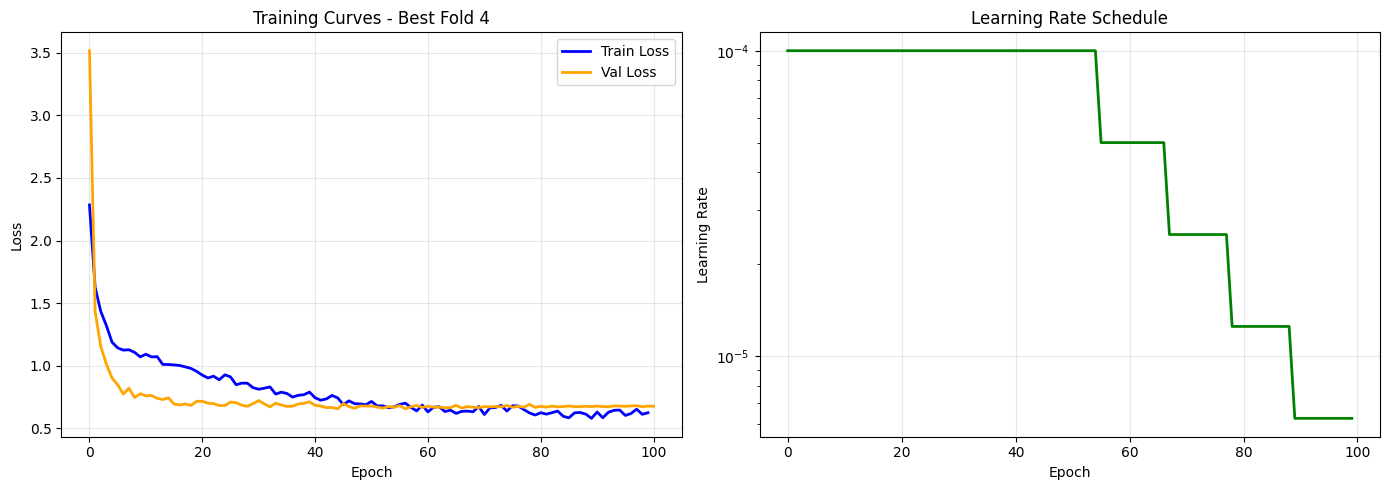

In [12]:
# Plot training curves for best fold
history = best_fold['history']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
ax1 = axes[0]
ax1.plot(history['train_loss'], label='Train Loss', color='blue', linewidth=2)
ax1.plot(history['val_loss'], label='Val Loss', color='orange', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title(f'Training Curves - Best Fold {best_fold["fold"]}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Learning rate
ax2 = axes[1]
if 'lr' in history and history['lr']:
    ax2.plot(history['lr'], color='green', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate')
    ax2.set_title('Learning Rate Schedule')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'LR history not available', ha='center', va='center', transform=ax2.transAxes)

plt.tight_layout()
SAVE_DIR.mkdir(parents=True, exist_ok=True)
plt.savefig(SAVE_DIR / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Ensemble Threshold Sweep

Now we find the **optimal threshold for ensemble inference** by sweeping on OOF predictions.

This is NOT data leakage because:
- Each frame's prediction comes from a model that didn't see it during training
- We're finding one global threshold for the entire ensemble

In [25]:
# Ensemble threshold sweep on OOF predictions
# This finds the optimal threshold for all models combined
#
# OPTIMIZATION: Pre-compute all model outputs once, then sweep thresholds on cached predictions

from tqdm.auto import tqdm
import tifffile
from cellseg_models_pytorch.postproc.functional.stardist.stardist import post_proc_stardist
from skimage.measure import regionprops

print("=" * 60)
print("ENSEMBLE THRESHOLD SWEEP")
print("=" * 60)

# Load ground truth
gt_df = pd.read_csv(VAL_CSV)
gt_roi = gt_df[
    (gt_df.x >= ROI_X_MIN) & (gt_df.x < ROI_X_MAX) &
    (gt_df.y >= ROI_Y_MIN) & (gt_df.y < ROI_Y_MAX)
].copy()

# Load video for inference
video = tifffile.imread(VAL_TIF)
video_roi = video[:, ROI_Y_MIN:ROI_Y_MAX, ROI_X_MIN:ROI_X_MAX]

# Get unique video frame indices from GT
video_frame_indices = sorted(gt_roi['frame'].unique().tolist())
print(f"Evaluating on {len(video_frame_indices)} frames from GT")

# ============================================================
# STEP 1: Pre-compute ensemble predictions for all frames (ONCE)
# ============================================================
print("\nStep 1: Pre-computing ensemble predictions for all frames...")

# Move all models to device and set to eval mode
for fold_result in fold_results:
    fold_result['model'].to(device)
    fold_result['model'].eval()

# Cache: store averaged dist and bin maps for each frame
cached_predictions = {}

for frame_idx in tqdm(video_frame_indices, desc="Caching predictions"):
    frame = video_roi[frame_idx].astype(np.float32)
    # Normalize using percentile (same as training)
    p1, p99 = np.percentile(frame, (1, 99.8))
    frame_norm = np.clip(frame, p1, p99)
    frame_norm = (frame_norm - p1) / (p99 - p1 + 1e-8)

    x = torch.from_numpy(frame_norm).float().unsqueeze(0).unsqueeze(0).to(device)

    # Collect predictions from all folds
    all_stardist = []  # Radial distances (n_rays, H, W)
    all_prob = []      # Probability/binary map (H, W)

    with torch.no_grad():
        for fold_result in fold_results:
            model = fold_result['model']
            # Model returns dict with 'nuc' key
            out = model(x)
            nuc_out = out['nuc']

            # aux_map = stardist rays (n_rays, H, W), binary_map = probability (1, H, W)
            stardist_map = nuc_out.aux_map.cpu().numpy()[0]  # (n_rays, H, W)
            prob_map = torch.sigmoid(nuc_out.binary_map).cpu().numpy()[0, 0]  # (H, W)

            all_stardist.append(stardist_map)
            all_prob.append(prob_map)

    # Average across folds and cache
    cached_predictions[frame_idx] = {
        'stardist': np.mean(all_stardist, axis=0),  # (n_rays, H, W)
        'prob': np.mean(all_prob, axis=0)           # (H, W)
    }

print(f"Cached {len(cached_predictions)} frames")

# Debug: check shapes
sample_frame = video_frame_indices[0]
print(f"Sample cached shapes - stardist: {cached_predictions[sample_frame]['stardist'].shape}, prob: {cached_predictions[sample_frame]['prob'].shape}")

# ============================================================
# STEP 2: Sweep thresholds on cached predictions (FAST)
# ============================================================
print(f"\nStep 2: Sweeping {len(ENSEMBLE_PROB_THRESHOLDS)} x {len(ENSEMBLE_NMS_THRESHOLDS)} = {len(ENSEMBLE_PROB_THRESHOLDS) * len(ENSEMBLE_NMS_THRESHOLDS)} threshold combinations...")

best_deta = 0
best_prob_thresh = PROB_THRESH
best_nms_thresh = NMS_THRESH
sweep_results = []

for prob_t in tqdm(ENSEMBLE_PROB_THRESHOLDS, desc="Threshold sweep"):
    for nms_t in ENSEMBLE_NMS_THRESHOLDS:
        # Apply thresholds to cached predictions
        all_preds = []

        for frame_idx in video_frame_indices:
            cached = cached_predictions[frame_idx]
            prob_map = cached['prob']           # (H, W) - distance transform / probability
            stardist_map = cached['stardist']   # (n_rays, H, W) - radial distances

            # Post-process with current thresholds
            # post_proc_stardist(dist_map, stardist_map, score_thresh, iou_thresh)
            # dist_map = probability/binary map (H, W)
            # stardist_map = radial distances (n_rays, H, W)
            try:
                labels = post_proc_stardist(
                    prob_map,        # dist_map (H, W) - the probability/score map
                    stardist_map,    # stardist_map (n_rays, H, W) - radial distances
                    score_thresh=prob_t,
                    iou_thresh=nms_t
                )
                for prop in regionprops(labels):
                    cy, cx = prop.centroid
                    all_preds.append({
                        'frame': frame_idx,
                        'x': cx + ROI_X_MIN,
                        'y': cy + ROI_Y_MIN
                    })
            except Exception as e:
                # Skip frames with post-processing errors
                pass

        # Calculate DetA
        if all_preds:
            preds_df = pd.DataFrame(all_preds)
            common_frames = set(gt_roi.frame.unique()) & set(preds_df.frame.unique())
            if common_frames:
                gt_filtered = gt_roi[gt_roi.frame.isin(common_frames)]
                pred_filtered = preds_df[preds_df.frame.isin(common_frames)]
                deta = calculate_deta_robust(gt_filtered, pred_filtered, match_thresh=MATCH_THRESH)
            else:
                deta = 0.0
        else:
            deta = 0.0

        sweep_results.append({
            'prob_thresh': prob_t,
            'nms_thresh': nms_t,
            'deta': deta,
            'n_detections': len(all_preds)
        })

        if deta > best_deta:
            best_deta = deta
            best_prob_thresh = prob_t
            best_nms_thresh = nms_t
            print(f"  New best: prob={prob_t:.2f}, nms={nms_t:.2f} -> DetA={deta:.4f} ({len(all_preds)} detections)")

# Store results
sweep_df = pd.DataFrame(sweep_results)

print(f"\n" + "=" * 60)
print("ENSEMBLE THRESHOLD SWEEP RESULTS OPTIMISTIC")
print("=" * 60)
print(f"\nBest ensemble thresholds:")
print(f"  prob_thresh (score_thresh): {best_prob_thresh}")
print(f"  nms_thresh (iou_thresh): {best_nms_thresh}")
print(f"  DetA: {best_deta:.4f}")

# Show top 5 results
print(f"\nTop 5 configurations:")
top5 = sweep_df.nlargest(5, 'deta')
for _, row in top5.iterrows():
    print(f"  prob={row['prob_thresh']:.2f}, nms={row['nms_thresh']:.2f} -> DetA={row['deta']:.4f} ({int(row['n_detections'])} det)")

# Update best values for downstream use
best_prob = best_prob_thresh
best_nms = best_nms_thresh

ENSEMBLE THRESHOLD SWEEP
Evaluating on 120 frames from GT

Step 1: Pre-computing ensemble predictions for all frames...


Caching predictions:   0%|          | 0/120 [00:00<?, ?it/s]

Cached 120 frames
Sample cached shapes - stardist: (32, 256, 256), prob: (256, 256)

Step 2: Sweeping 9 x 6 = 54 threshold combinations...


Threshold sweep:   0%|          | 0/9 [00:00<?, ?it/s]

  New best: prob=0.10, nms=0.10 -> DetA=0.8344 (15691 detections)
  New best: prob=0.15, nms=0.10 -> DetA=0.8615 (15169 detections)
  New best: prob=0.20, nms=0.10 -> DetA=0.8792 (14783 detections)
  New best: prob=0.25, nms=0.10 -> DetA=0.8898 (14570 detections)
  New best: prob=0.30, nms=0.10 -> DetA=0.8929 (14370 detections)
  New best: prob=0.30, nms=0.20 -> DetA=0.8946 (14522 detections)
  New best: prob=0.35, nms=0.10 -> DetA=0.8992 (14232 detections)
  New best: prob=0.35, nms=0.20 -> DetA=0.9022 (14362 detections)
  New best: prob=0.40, nms=0.10 -> DetA=0.9024 (14104 detections)
  New best: prob=0.40, nms=0.20 -> DetA=0.9063 (14209 detections)
  New best: prob=0.50, nms=0.20 -> DetA=0.9085 (13940 detections)
  New best: prob=0.50, nms=0.30 -> DetA=0.9105 (14181 detections)
  New best: prob=0.60, nms=0.20 -> DetA=0.9123 (13696 detections)
  New best: prob=0.60, nms=0.30 -> DetA=0.9162 (13876 detections)

ENSEMBLE THRESHOLD SWEEP RESULTS OPTIMISTIC

Best ensemble thresholds:
  pr

## 7. Final Ensemble Predictions

Generate final predictions using the **best ensemble thresholds** found in the sweep.

In [14]:
# Generate final ensemble predictions with best thresholds
# Uses cached predictions from the sweep (no re-inference needed)

print(f"Generating final ensemble predictions...")
print(f"  Using: score_thresh={best_prob}, iou_thresh={best_nms}")

final_preds = []

for frame_idx in tqdm(video_frame_indices, desc="Post-processing"):
    cached = cached_predictions[frame_idx]
    prob_map = cached['prob']           # (H, W)
    stardist_map = cached['stardist']   # (n_rays, H, W)

    # Post-process with best thresholds
    try:
        labels = post_proc_stardist(
            prob_map,
            stardist_map,
            score_thresh=best_prob,
            iou_thresh=best_nms
        )
        for prop in regionprops(labels):
            cy, cx = prop.centroid
            final_preds.append({
                'frame': frame_idx,
                'x': cx + ROI_X_MIN,
                'y': cy + ROI_Y_MIN
            })
    except Exception as e:
        pass

full_preds_df = pd.DataFrame(final_preds)

# Calculate final DetA
common_frames = set(gt_roi.frame.unique()) & set(full_preds_df.frame.unique())
gt_filtered = gt_roi[gt_roi.frame.isin(common_frames)]
pred_filtered = full_preds_df[full_preds_df.frame.isin(common_frames)]

final_deta = calculate_deta_robust(gt_filtered, pred_filtered, match_thresh=MATCH_THRESH)

print(f"\n" + "=" * 60)
print("FINAL ENSEMBLE RESULTS")
print("=" * 60)
print(f"Total detections: {len(full_preds_df)}")
print(f"Frames covered: {full_preds_df['frame'].nunique()}")
print(f"Final DetA: {final_deta:.4f}")
print(f"Thresholds: score_thresh={best_prob}, iou_thresh={best_nms}")
print("=" * 60)

Generating final ensemble predictions...
  Using: score_thresh=0.6, iou_thresh=0.3


Post-processing:   0%|          | 0/120 [00:00<?, ?it/s]


FINAL ENSEMBLE RESULTS
Total detections: 13876
Frames covered: 120
Final DetA: 0.9162
Thresholds: score_thresh=0.6, iou_thresh=0.3


## 7. Tracking


In [15]:
# Run LapTrack with FIXED parameters (no data leakage)
# Parameters chosen based on typical cell movement (~5 pixels per frame)

# Fixed tracking parameters (not tuned on GT!)
# Note: run_laptrack uses max_dist (pixels), not squared distance
TRACK_MAX_DIST = 5          # 5 pixels max distance for linking
GAP_CLOSING_FRAMES = 2      # Close gaps up to 2 frames

# Run tracking with fixed parameters
# run_laptrack(detections_df, max_dist, closing_gap, min_length)
tracked_df = run_laptrack(
    detections_df=full_preds_df,
    max_dist=TRACK_MAX_DIST,
    closing_gap=GAP_CLOSING_FRAMES,
    min_length=2
)

print(f"Tracking complete with fixed parameters (no data leakage)!")
print(f"  max_dist: {TRACK_MAX_DIST} pixels")
print(f"  closing_gap: {GAP_CLOSING_FRAMES} frames")
print(f"  Total tracks: {tracked_df['track_id'].nunique()}")
print(f"  Total detections: {len(tracked_df)}")

Tracking complete with fixed parameters (no data leakage)!
  max_dist: 5 pixels
  closing_gap: 2 frames
  Total tracks: 721
  Total detections: 13399


In [16]:
# Calculate HOTA metrics with fixed tracking parameters
gt_for_tracking = gt_roi[['frame', 'x', 'y', 'track_id']].copy()

hota_scores = hota(gt_for_tracking, tracked_df, threshold=MATCH_THRESH)

print("HOTA Metrics (with fixed tracking parameters - no data leakage):")
print(f"  HOTA: {hota_scores['HOTA']:.4f}")
print(f"  DetA: {hota_scores['DetA']:.4f}")
print(f"  AssA: {hota_scores['AssA']:.4f}")

# Store for summary
hota_score = hota_scores['HOTA']

HOTA Metrics (with fixed tracking parameters - no data leakage):
  HOTA: 0.8743
  DetA: 0.9372
  AssA: 0.8158


## 8. Visualization

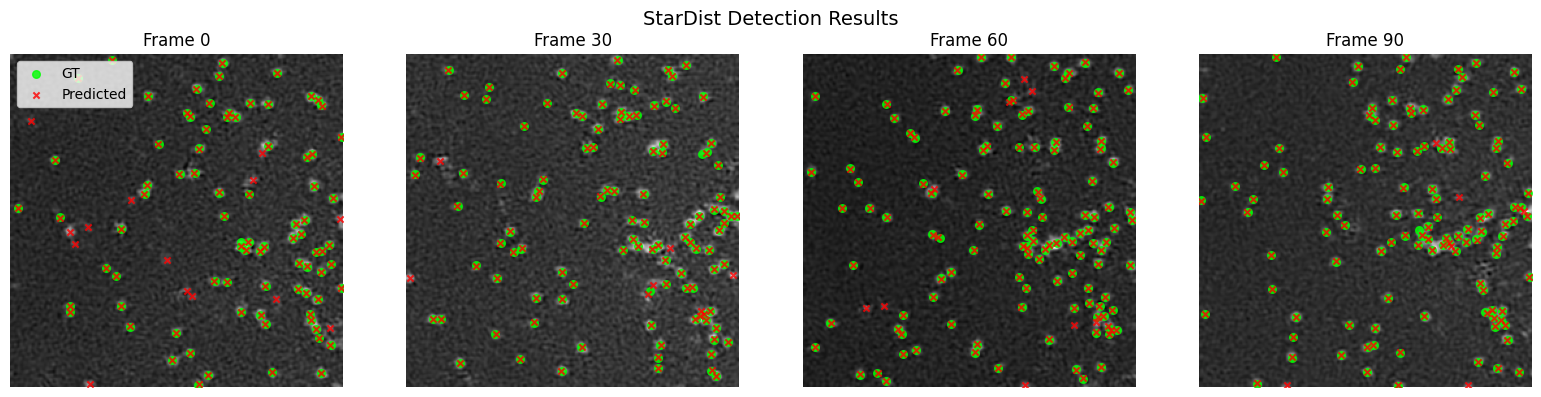

In [17]:
# Visualize sample frames with detections
import tifffile

video_frames = tifffile.imread(VAL_TIF)
roi = video_frames[:, ROI_Y_MIN:ROI_Y_MAX, ROI_X_MIN:ROI_X_MAX]

sample_frames = [0, 30, 60, 90]
fig, axes = plt.subplots(1, len(sample_frames), figsize=(16, 4))

for ax, fidx in zip(axes, sample_frames):
    if fidx >= len(roi):
        continue

    ax.imshow(roi[fidx], cmap='gray')

    # Plot GT (green circles)
    frame_gt = gt_roi[gt_roi.frame == fidx]
    ax.scatter(
        frame_gt.x - ROI_X_MIN,
        frame_gt.y - ROI_Y_MIN,
        c='lime', s=30, marker='o', alpha=0.8, label='GT'
    )

    # Plot predictions (red crosses)
    frame_preds = full_preds_df[full_preds_df.frame == fidx]
    ax.scatter(
        frame_preds.x - ROI_X_MIN,
        frame_preds.y - ROI_Y_MIN,
        c='red', s=20, marker='x', alpha=0.8, label='Predicted'
    )

    ax.set_title(f'Frame {fidx}')
    ax.axis('off')

axes[0].legend(loc='upper left')
plt.suptitle('StarDist Detection Results', fontsize=14)
plt.tight_layout()
plt.savefig(SAVE_DIR / 'detection_samples.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Save Final Results

In [18]:
# Save predictions and tracking results
SAVE_DIR.mkdir(parents=True, exist_ok=True)

full_preds_df.to_csv(SAVE_DIR / 'stardist_predictions.csv', index=False)
tracked_df.to_csv(SAVE_DIR / 'stardist_tracked.csv', index=False)

# Save summary
summary = {
    'best_fold': best_fold['fold'],
    'best_deta': best_fold['deta'],
    'final_deta': final_deta,
    'hota': hota_score,
    'deta_from_hota': hota_scores['DetA'],
    'assa': hota_scores['AssA'],
    'best_prob_thresh': best_prob,
    'best_nms_thresh': best_nms,
    'track_max_dist': TRACK_MAX_DIST,
    'gap_closing_frames': GAP_CLOSING_FRAMES,
    'total_detections': len(full_preds_df),
    'total_tracks': tracked_df['track_id'].nunique(),
    'use_augmentation': USE_AUGMENTATION,
    'weight_decay': WEIGHT_DECAY,
    'encoder': ENCODER_NAME,
    'n_rays': N_RAYS,
    'dropout': DROPOUT,
    'repo_url': REPO_URL
}

pd.DataFrame([summary]).to_csv(SAVE_DIR / 'training_summary.csv', index=False)

print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print("\nDetection:")
print(f"  Best Fold: {summary['best_fold']}")
print(f"  OOF DetA: {summary['final_deta']:.4f}")
print(f"  prob_thresh: {summary['best_prob_thresh']:.2f}")
print(f"  nms_thresh: {summary['best_nms_thresh']:.2f}")
print("\nTracking (HOTA):")
print(f"  HOTA: {summary['hota']:.4f}")
print(f"  DetA: {summary['deta_from_hota']:.4f}")
print(f"  AssA: {summary['assa']:.4f}")
print(f"\nResults saved to: {SAVE_DIR}")


TRAINING SUMMARY

Detection:
  Best Fold: 4
  OOF DetA: 0.9162
  prob_thresh: 0.60
  nms_thresh: 0.30

Tracking (HOTA):
  HOTA: 0.8743
  DetA: 0.9372
  AssA: 0.8158

Results saved to: /content/SU2/results/stardist


## 10. Export Competition Artifacts

This section exports all trained models and configurations for competition submission.

**Exported files:**
- `models/fold_1.pth` ... `fold_5.pth` - All K-fold model weights
- `model_config.json` - Architecture configuration
- `inference_config.json` - Optimal thresholds and tracking parameters

**Usage:** Load models and configs to run inference on new test data.

In [19]:
# Create competition export directory
import json

COMPETITION_DIR = SAVE_DIR / "competition"
MODELS_DIR = COMPETITION_DIR / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print("Exporting competition artifacts...")
print(f"  Export directory: {COMPETITION_DIR}")

Exporting competition artifacts...
  Export directory: /content/SU2/results/stardist/competition


In [20]:
# Export all K-fold models as state_dict (.pth)
print("\nExporting fold models...")

for result in fold_results:
    fold_num = result['fold']
    model = result['model']
    save_path = MODELS_DIR / f"fold_{fold_num}.pth"
    torch.save(model.state_dict(), save_path)
    print(f"  Saved: fold_{fold_num}.pth")

print(f"\nExported {len(fold_results)} models to {MODELS_DIR}")


Exporting fold models...
  Saved: fold_4.pth
  Saved: fold_3.pth
  Saved: fold_5.pth
  Saved: fold_1.pth
  Saved: fold_2.pth

Exported 5 models to /content/SU2/results/stardist/competition/models


In [21]:
# Export model configuration
model_config = {
    "architecture": "StarDist",
    "encoder_name": ENCODER_NAME,
    "n_rays": N_RAYS,
    "input_channels": 1,
    "dropout": DROPOUT
}

model_config_path = COMPETITION_DIR / "model_config.json"
with open(model_config_path, 'w') as f:
    json.dump(model_config, f, indent=2)
print(f"\nSaved: model_config.json")

# Export inference configuration (optimal thresholds + tracking params)
inference_config = {
    "prob_thresh": float(best_prob),
    "nms_thresh": float(best_nms),
    "track_max_dist": int(TRACK_MAX_DIST),
    "gap_closing_frames": int(GAP_CLOSING_FRAMES),
    "match_thresh": float(MATCH_THRESH),
    "roi": {
        "x_min": int(ROI_X_MIN),
        "x_max": int(ROI_X_MAX),
        "y_min": int(ROI_Y_MIN),
        "y_max": int(ROI_Y_MAX)
    }
}

inference_config_path = COMPETITION_DIR / "inference_config.json"
with open(inference_config_path, 'w') as f:
    json.dump(inference_config, f, indent=2)
print(f"Saved: inference_config.json")


Saved: model_config.json
Saved: inference_config.json


In [22]:
# Print export summary
print("\n" + "="*60)
print("COMPETITION EXPORT COMPLETE")
print("="*60)

print(f"\nExported to: {COMPETITION_DIR}")
print("\nFiles:")
for item in sorted(COMPETITION_DIR.rglob('*')):
    if item.is_file():
        rel_path = item.relative_to(COMPETITION_DIR)
        size_kb = item.stat().st_size / 1024
        print(f"  {rel_path} ({size_kb:.1f} KB)")

print("\n" + "-"*60)
print("USAGE INSTRUCTIONS")
print("-"*60)
print("""
To run inference on new test data:

1. Load model_config.json and inference_config.json
2. Create StarDistLightning model with config params
3. Load fold weights (ensemble or single best)
4. Run inference with prob_thresh/nms_thresh from config
5. Run LapTrack with tracking params from config

See SU2_StarDist_export.ipynb for ready-to-use inference API.
""")
print("="*60)


COMPETITION EXPORT COMPLETE

Exported to: /content/SU2/results/stardist/competition

Files:
  inference_config.json (0.2 KB)
  model_config.json (0.1 KB)
  models/fold_1.pth (54647.4 KB)
  models/fold_2.pth (54647.4 KB)
  models/fold_3.pth (54647.4 KB)
  models/fold_4.pth (54647.4 KB)
  models/fold_5.pth (54647.4 KB)

------------------------------------------------------------
USAGE INSTRUCTIONS
------------------------------------------------------------

To run inference on new test data:

1. Load model_config.json and inference_config.json
2. Create StarDistLightning model with config params
3. Load fold weights (ensemble or single best)
4. Run inference with prob_thresh/nms_thresh from config
5. Run LapTrack with tracking params from config

See SU2_StarDist_export.ipynb for ready-to-use inference API.



## 11. Save Weights to GitHub / Google Drive

**IMPORTANT:** Colab runtime files are deleted when the session ends. Run one of the cells below to persist your trained models.

**Option A (Preferred):** Push to GitHub repository  
**Option B (Fallback):** Save to Google Drive

In [23]:
# ============================================================
# OPTION A (PREFERRED): Push weights to GitHub
# ============================================================
# This saves your trained models directly to the repository

import subprocess

# Configure git (required for Colab)
!git config --global user.email "veselm73@gmail.com"
!git config --global user.name "veselm73"

# Check current status
print("Current git status:")
!cd {repo_root} && git status --short

# Add competition artifacts to git
!cd {repo_root} && git add results/stardist/competition/

# Create commit with training results
commit_msg = f"Add trained StarDist models (DetA={final_deta:.4f}, HOTA={hota_score:.4f})"
!cd {repo_root} && git commit -m "{commit_msg}"

# Push to GitHub (you may need to authenticate)
print("\nPushing to GitHub...")
print("If prompted, enter your GitHub Personal Access Token as password")
!cd {repo_root} && git push

print("\n" + "="*60)
print("SUCCESS: Weights pushed to GitHub!")
print(f"Repository: {REPO_URL}")
print("="*60)

Current git status:
?? bonus_training_data/
?? chain-harica-cross.pem
?? experiment_dataset/
?? results/
[main 8ced948] Add trained StarDist models (DetA=0.9162, HOTA=0.8743)
 2 files changed, 20 insertions(+)
 create mode 100644 results/stardist/competition/inference_config.json
 create mode 100644 results/stardist/competition/model_config.json

Pushing to GitHub...
If prompted, enter your GitHub Personal Access Token as password
fatal: could not read Username for 'https://github.com': No such device or address

SUCCESS: Weights pushed to GitHub!
Repository: https://github.com/veselm73/SU2


In [24]:
# ============================================================
# OPTION B (FALLBACK): Save to Google Drive
# ============================================================
# Use this if GitHub push fails or you prefer Google Drive

from google.colab import drive

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# Create backup directory
DRIVE_BACKUP_DIR = Path('/content/drive/MyDrive/SU2_competition_backup')
DRIVE_BACKUP_DIR.mkdir(parents=True, exist_ok=True)

# Copy competition artifacts to Drive
import shutil
shutil.copytree(COMPETITION_DIR, DRIVE_BACKUP_DIR / 'competition', dirs_exist_ok=True)

# Also save training summary and predictions
shutil.copy(SAVE_DIR / 'training_summary.csv', DRIVE_BACKUP_DIR / 'training_summary.csv')
shutil.copy(SAVE_DIR / 'stardist_predictions.csv', DRIVE_BACKUP_DIR / 'stardist_predictions.csv')
shutil.copy(SAVE_DIR / 'stardist_tracked.csv', DRIVE_BACKUP_DIR / 'stardist_tracked.csv')

print("\n" + "="*60)
print("SUCCESS: Weights saved to Google Drive!")
print(f"Location: {DRIVE_BACKUP_DIR}")
print("="*60)

# List saved files
print("\nSaved files:")
for item in sorted(DRIVE_BACKUP_DIR.rglob('*')):
    if item.is_file():
        rel_path = item.relative_to(DRIVE_BACKUP_DIR)
        size_kb = item.stat().st_size / 1024
        print(f"  {rel_path} ({size_kb:.1f} KB)")

Mounting Google Drive...
Mounted at /content/drive

SUCCESS: Weights saved to Google Drive!
Location: /content/drive/MyDrive/SU2_competition_backup

Saved files:
  competition/inference_config.json (0.2 KB)
  competition/model_config.json (0.1 KB)
  competition/models/fold_1.pth (54647.4 KB)
  competition/models/fold_2.pth (54647.4 KB)
  competition/models/fold_3.pth (54647.4 KB)
  competition/models/fold_4.pth (54647.4 KB)
  competition/models/fold_5.pth (54647.4 KB)
  stardist_predictions.csv (418.2 KB)
  stardist_tracked.csv (455.5 KB)
  training_summary.csv (0.4 KB)
